In [1]:
import os
import numpy as np
import scipy
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, LSTM,MaxPooling2D, Flatten, Dense,Dropout,Bidirectional , Activation, Add,Concatenate
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.regularizers import l2

2024-05-17 14:00:21.223167: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 14:00:21.252401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 14:00:21.252429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 14:00:21.253304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 14:00:21.258301: I tensorflow/core/platform/cpu_feature_guar

In [2]:
x = np.load('EEG_X_train.npy')
y = np.load('EEG_y_train.npy')
x_val = np.load('EEG_X_test.npy')
y_val = np.load('EEG_y_test.npy')

In [3]:
print("x shape is {}".format(x.shape))
print("y shape is {}".format(y.shape))

x shape is (191, 1280, 19)
y shape is (191, 1)


In [4]:

input_shape = x.shape[1:]
l2_strength = 0.01

model = Sequential([
    Conv1D(32, 3, activation='elu', input_shape=input_shape, padding='same'),
    Conv1D(128, 3, activation='elu', padding='same'),
    LSTM(256, activation='tanh', recurrent_activation='sigmoid', return_sequences=True,
         recurrent_regularizer=l2(l2_strength)),
    LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True,
         recurrent_regularizer=l2(l2_strength)),
    LSTM(16, activation='tanh', recurrent_activation='sigmoid', return_sequences=True,
         recurrent_regularizer=l2(l2_strength)),
    Flatten(),
    Dense(64, activation='elu', kernel_regularizer=l2(l2_strength)),
    Dense(3, activation='linear')
])

2024-05-17 14:00:23.405166: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 14:00:23.424605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 14:00:23.424675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 14:00:23.427921: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 14:00:23.428012: I external/local_xla/xla/stream_executor

In [5]:
model.build()
#model.summary()
#model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(0.001),metrics=['accuracy'])

In [6]:
#model = tf.keras.models.load_model("model_cnn_v1.h5")

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1280, 32)          1856      
                                                                 
 conv1d_1 (Conv1D)           (None, 1280, 128)         12416     
                                                                 
 lstm (LSTM)                 (None, 1280, 256)         394240    
                                                                 
 lstm_1 (LSTM)               (None, 1280, 64)          82176     
                                                                 
 lstm_2 (LSTM)               (None, 1280, 16)          5184      
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 64)                1

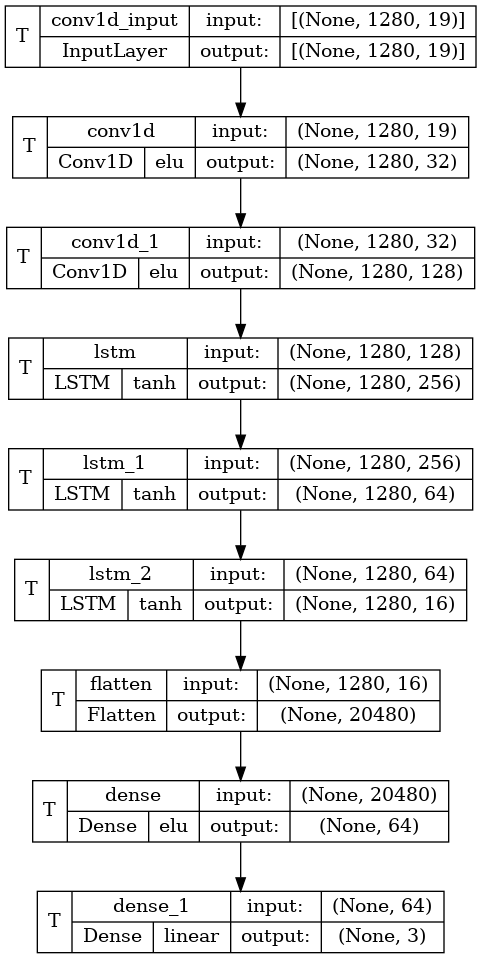

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file='model_diagram.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # 'TB' for vertical, 'LR' for horizontal
    expand_nested=True,
    show_layer_activations=True,
    show_trainable=True,
)

In [9]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
loss = loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [10]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.00001, mode='min')
model_checkpoint = ModelCheckpoint("model_lstm_max_accuracy.keras", monitor='val_accuracy', save_best_only=True, mode='max')
model_checkpoint_1 = ModelCheckpoint("model_lstm_min_loss.keras", monitor='val_loss', save_best_only=True, mode='min')
history = model.fit(x, y, batch_size=128, epochs=400, validation_data=[x_val,y_val], callbacks=[ model_checkpoint,model_checkpoint_1], verbose=1)

Epoch 1/400


2024-05-17 14:00:30.894869: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-17 14:00:30.975431: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-17 14:00:31.801356: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f41c2a803e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 14:00:31.801398: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-05-17 14:00:31.806951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715934631.854647   73914 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 6s 2s/step - loss: 5.7208 - accuracy: 0.3351 - val_loss: 5.6519 - val_accuracy: 0.3636
Epoch 2/400
2/2 [==============================] - 1s 561ms/step - loss: 5.6422 - accuracy: 0.3246 - val_loss: 5.5841 - val_accuracy: 0.3182
Epoch 3/400
2/2 [==============================] - 1s 522ms/step - loss: 5.5741 - accuracy: 0.3455 - val_loss: 5.5233 - val_accuracy: 0.3182
Epoch 4/400
2/2 [==============================] - 1s 534ms/step - loss: 5.5146 - accuracy: 0.3351 - val_loss: 5.4660 - val_accuracy: 0.3182
Epoch 5/400
2/2 [==============================] - 1s 510ms/step - loss: 5.4576 - accuracy: 0.3351 - val_loss: 5.4111 - val_accuracy: 0.3636
Epoch 6/400
2/2 [==============================] - 1s 540ms/step - loss: 5.4029 - accuracy: 0.3298 - val_loss: 5.3597 - val_accuracy: 0.3182
Epoch 7/400
2/2 [==============================] - 1s 559ms/step - loss: 5.3511 - accuracy: 0.3298 - val_loss: 5.3097 - val_accuracy: 0.3182
Epoch 8/400
2/2 [===========